In [1]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [2]:
train_file = 'train.parquet'
train_table = pq.read_table(train_file)

In [3]:
train_df = train_table.to_pandas()

In [4]:
train_df.head()

Patient-Uid       Date           Incident
0  a0db1e73-1c7c-11ec-ae39-16262ee38c7f 2019-03-09  PRIMARY_DIAGNOSIS
1  a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f 2015-05-16  PRIMARY_DIAGNOSIS
3  a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f 2018-01-30     SYMPTOM_TYPE_0
4  a0dc950b-1c7c-11ec-b6ec-16262ee38c7f 2015-04-22        DRUG_TYPE_0
8  a0dc9543-1c7c-11ec-bb63-16262ee38c7f 2016-06-18        DRUG_TYPE_1

In [5]:
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [6]:
target_drug = train_df[train_df['Incident'] == 'TARGET DRUG']

In [7]:
target_drug.head()

Patient-Uid       Date     Incident
3294791  a0eb742b-1c7c-11ec-8f61-16262ee38c7f 2020-04-09  TARGET DRUG
3296990  a0edaf09-1c7c-11ec-a360-16262ee38c7f 2018-06-12  TARGET DRUG
3305387  a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f 2019-06-11  TARGET DRUG
3309423  a0ecc615-1c7c-11ec-aa31-16262ee38c7f 2019-11-15  TARGET DRUG
3309494  a0ea612f-1c7c-11ec-8cf0-16262ee38c7f 2020-03-18  TARGET DRUG

In [8]:
grouped_df = target_drug.groupby('Patient-Uid')

In [9]:
first_prescription_dates = grouped_df['Date'].first().reset_index()

In [10]:
first_prescription_dates

Patient-Uid       Date
0     a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-08-05
1     a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-08-09
2     a0e9c3e3-1c7c-11ec-a8b9-16262ee38c7f 2020-05-26
3     a0e9c414-1c7c-11ec-889a-16262ee38c7f 2019-02-22
4     a0e9c443-1c7c-11ec-9eb0-16262ee38c7f 2019-12-06
...                                    ...        ...
9369  a0f0d4c5-1c7c-11ec-bfec-16262ee38c7f 2020-08-05
9370  a0f0d4f4-1c7c-11ec-b144-16262ee38c7f 2020-07-18
9371  a0f0d523-1c7c-11ec-89d2-16262ee38c7f 2020-06-17
9372  a0f0d553-1c7c-11ec-a70a-16262ee38c7f 2020-07-21
9373  a0f0d582-1c7c-11ec-a6c1-16262ee38c7f 2020-08-05

[9374 rows x 2 columns]

In [11]:
first_prescription_dates = first_prescription_dates.rename(columns={'Date': 'first_prescription_date'})

In [12]:
target_drug = pd.merge(target_drug, first_prescription_dates, on='Patient-Uid', how='left')

In [13]:
target_drug.head()

Patient-Uid       Date     Incident  \
0  a0eb742b-1c7c-11ec-8f61-16262ee38c7f 2020-04-09  TARGET DRUG   
1  a0edaf09-1c7c-11ec-a360-16262ee38c7f 2018-06-12  TARGET DRUG   
2  a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f 2019-06-11  TARGET DRUG   
3  a0ecc615-1c7c-11ec-aa31-16262ee38c7f 2019-11-15  TARGET DRUG   
4  a0ea612f-1c7c-11ec-8cf0-16262ee38c7f 2020-03-18  TARGET DRUG   

  first_prescription_date  
0              2020-04-09  
1              2018-06-12  
2              2019-06-11  
3              2019-11-15  
4              2020-03-18

In [14]:
target_drug['months_between_events'] = ((target_drug['Date'] - target_drug['first_prescription_date']) / np.timedelta64(1, 'M')) % 12

In [15]:
target_drug.head()

Patient-Uid       Date     Incident  \
0  a0eb742b-1c7c-11ec-8f61-16262ee38c7f 2020-04-09  TARGET DRUG   
1  a0edaf09-1c7c-11ec-a360-16262ee38c7f 2018-06-12  TARGET DRUG   
2  a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f 2019-06-11  TARGET DRUG   
3  a0ecc615-1c7c-11ec-aa31-16262ee38c7f 2019-11-15  TARGET DRUG   
4  a0ea612f-1c7c-11ec-8cf0-16262ee38c7f 2020-03-18  TARGET DRUG   

  first_prescription_date  months_between_events  
0              2020-04-09                    0.0  
1              2018-06-12                    0.0  
2              2019-06-11                    0.0  
3              2019-11-15                    0.0  
4              2020-03-18                    0.0

In [16]:
target_drug.shape

(67218, 5)

In [17]:
target_drug.months_between_events.value_counts()

0.000000     9374
10.160126    1276
1.839874     1267
3.679747      681
8.320253      676
             ... 
5.700815        1
9.748948        1
7.547670        1
2.282922        1
7.047865        1
Name: months_between_events, Length: 1711, dtype: int64

In [18]:
grouped = target_drug.groupby('months_between_events')
patient_counts = grouped['Patient-Uid'].nunique()

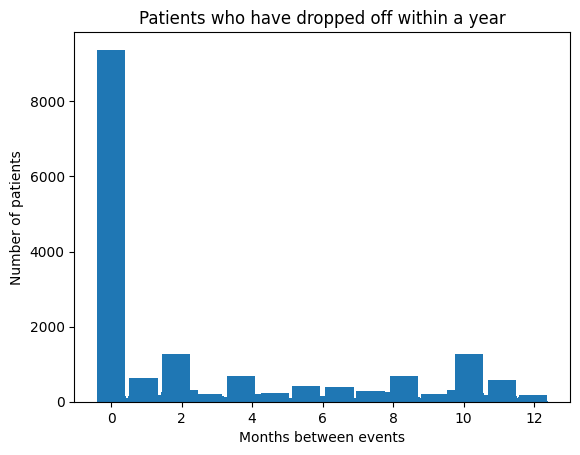

In [19]:
plt.bar(patient_counts.index, patient_counts.values)
plt.xlabel('Months between events')
plt.ylabel('Number of patients')
plt.title('Patients who have dropped off within a year')
plt.show()

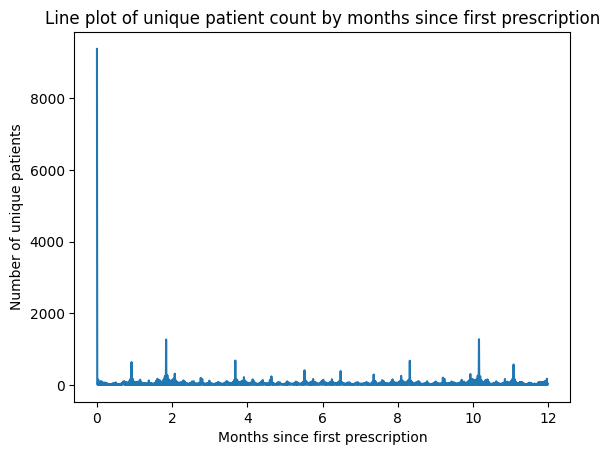

In [20]:
patient_counts.plot(kind='line')
plt.xlabel('Months since first prescription')
plt.ylabel('Number of unique patients')
plt.title('Line plot of unique patient count by months since first prescription')
plt.show()